In [396]:
import warnings
warnings.filterwarnings('ignore')

import sox
import tempfile
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.io.wavfile import read
from scipy.fftpack import fft
import scipy.optimize as opt
import scipy.integrate as integrate

FILE = '/Users/sam/Downloads/Bass-Drum-1.wav'
OFILE = './processed.wav'

from plots import t_plot, f_plot
from compression import compress, optimise_compression

In [415]:
def equalise(x, scaling):
    dbs = scaling*np.array(x)
    
    tf = sox.Transformer()
    f = np.logspace(1.4, 4, len(dbs))
    for _f, db in zip(f, dbs):
        tf.equalizer(_f, 1.0, db)
    return tf

def equaliser_diff(f1, f2):
    dt = 0.05
    
    wav1 = read(f1)
    data = np.array(wav1[1],dtype=float)[:,0]

    # take 0.1 seconds after peak
    abs_data = np.abs(data)
    max_loc = np.where(abs_data==abs_data.max())[0][0]
    sample_data_0 = data[max_loc:max_loc+int(wav1[0]*dt)]
    y0 = fft(sample_data_0)

    # Number of samplepoints
    N = len(sample_data_0)
    # sample spacing
    T = 1.0 / wav1[0]
    x = np.linspace(0.0, 1.0/(2.0*T), N/2)

    wav2 = read(f2)
    data = np.array(wav2[1], dtype=float)[:,0]

    assert(wav2[0] == wav1[0])

    # take 0.1 seconds after peak
    abs_data = np.abs(data)
    max_loc = np.where(abs_data==abs_data.max())[0][0]
    sample_data_1 = data[max_loc:max_loc+int(wav1[0]*dt)]
    y1 = fft(sample_data_1)
    
    if (len(y1) != len(y0)):
        raise Exception()

    dy = np.log(np.abs(y1[:N//2])) - np.log(np.abs(y0[:N//2]))
    f = np.abs(dy)
    return x, f

def equaliser_bindiff(f1, f2):
    x, f = equaliser_diff(f1, f2)
    lrange = np.logspace(1.4, 4, 24)[:]
    bins = []
    for lower, upper in zip(lrange[:-1], lrange[1:]):
        indices = np.where(np.logical_and(x >= lower, x < upper))[0]
        if len(indices) > 0:
            bins.append(f[indices].sum()/len(indices))
        else:
            bins.append(0)

    bins = np.array(bins)
    return lrange[:-1], bins

def equaliser_lse(f1, f2):
    try:
        bins = equaliser_bindiff(f1, f2)[1]
    except:
        return 1e9
    
    if np.logical_not(np.isnan(bins)).sum() > 0:
        try:
            return np.sum(bins[np.logical_not(np.isnan(bins))])
        except Exception:
            return 1e9
    else:
        return np.sum(bins)

def ef(x, *args):    
    original, target, scaling = args
    temp = tempfile.mktemp()+'.wav'
    tf = equalise(x, scaling)
    try:
        os.remove(temp)
    except:
        None
        
    success = tf.build(original, temp)
    val = equaliser_lse(target, temp)
    print(val)
    return val
    
def optimise_equalisation(source_file, target_file, scaling, callback=None):
    bounds = np.array(
        [[-100, 100]]*len(scaling)
    )
    bounds = np.array((bounds.T[0], bounds.T[1])/scaling).T
    bounds.sort(axis=1)
    
    args = (source_file, target_file, scaling)
    
    print(bounds)
    return opt.brute(
        ef,  
        ranges=bounds,
        args=(source_file, target_file, scaling), 
        disp=True,
        full_output=True,
        finish=opt.fmin,
#         Ns=3
    )
    
#     return opt.minimize(
#         ef, 
#         np.ones(scaling.shape), 
#         (source_file, target_file, scaling), 
#         method="L-BFGS-B", 
#         bounds=bounds,
#         callback=callback,
#         options={
#             'eps': 1e-2, 'ftol': 1e-9, 'gtol': 1e-07
#         }
#     )

#     class RandomDisplacementBounds(object):
#         """random displacement with bounds"""
#         def __init__(self, xmin, xmax, stepsize=0.5):
#             self.xmin = xmin
#             self.xmax = xmax
#             self.stepsize = stepsize

#         def __call__(self, x):
#             """take a random step but ensure the new position is within the bounds"""
#             while True:
#                 # this could be done in a much more clever way, but it will work for example purposes
#                 xnew = x + np.random.uniform(-self.stepsize, self.stepsize, np.shape(x))
#                 if np.all(xnew < self.xmax) and np.all(xnew > self.xmin):
#                     break
#             return xnew

#     # define the new step taking routine and pass it to basinhopping
#     take_step = RandomDisplacementBounds(bounds.T[0], bounds.T[1])
#     minimizer_kwargs = {
#         "args": args, "method": "L-BFGS-B", "bounds": bounds,
#         "options": {
#             'eps': 1e-1, 'ftol': 1e-8, 'gtol': 1e-07
#         }
#     }

#     print('starting optimisation...')
#     return opt.basinhopping(ef, np.ones(scaling.shape), minimizer_kwargs=minimizer_kwargs,
#                             niter=50, take_step=take_step, callback=callback)

7.350977426603048


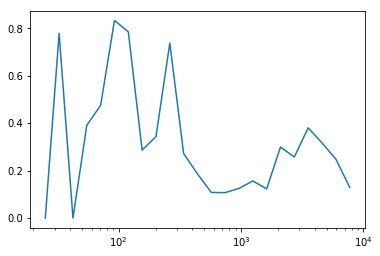

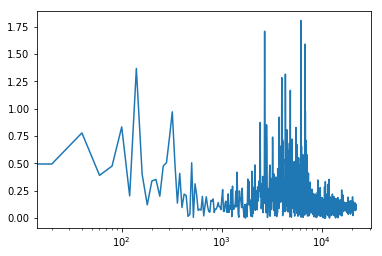

[[-10.  10.]
 [-10.  10.]
 [-10.  10.]
 [-10.  10.]
 [-10.  10.]]
217.16922897266136
217.16922897266136
213.10292394053832
211.5489965332551
210.52736538696192
209.22002621648167
210.58750040366638
208.58666725418388
229.1511932778067
229.30367339625087
226.4302414805025
224.96255089922127
224.17780376580413
225.3881650363974
217.80571356718036
217.56193517732467
209.77188204832703
181.27287800149196
168.0974414191554
154.12556484592062
140.22988330079568
211.48218242767857
210.44128962485814
208.97177842443824
209.90708918735098
208.48757089808225
224.1125253859429
224.76124726888526
219.88451148527372
219.88459668649688
220.39425823920962
219.32496208095688
221.58245973029895
217.82950336932217
211.3180474177316
208.12178385000672
182.93550187431998
168.70470086856545
154.86748866163043
141.2442523742592
127.3124518396686
211.43172041367066
208.62942533000364
208.5598602613962
208.97714641048427
224.03463034311034
219.02795822070078
214.83571859028115
216.03189396443966
212.520132203

209.6925924706082
209.6661575021191
209.55423997199745
217.49952347413603
213.55332993256167
211.40196639241967
209.08656927109584
207.67007773358714
207.09967781747577
208.05126568271461
208.32589123419498
200.75728684052208
192.79213168336088
184.6938026923726
164.79551293566902
143.49668405618112
129.98313071720537
120.2517891347863
102.42016055382223
210.27233638811455
210.0480491966525
210.71437852043033
217.57564967083184
217.29834449459744
211.47678612144085
205.8214153087436
204.17127065935307
203.14309261054655
203.00036933996444
200.88896843472676
197.62594190123144
191.0848619198342
181.22651456847439
163.65440580370478
150.936763194619
137.6385885227131
124.28222802224275
106.62427916824565
89.19847842665618
207.51542025557518
207.8969317862899
212.07663043160966
219.1758271742548
214.03608621893974
206.70429851010485
202.55982391730254
202.25760178872488
199.91470207226615
199.52993536869764
196.88886462739183
191.6157895179503
179.8720759797162
180.60973572824432
164.5990

203.78440416046294
202.44697889259928
195.87784863049026
195.82245828769626
197.26467721723208
192.45501878604813
180.5995156135265
180.78910626896726
163.66473353537012
148.53847151009708
126.55407722795512
114.20647115119604
101.89060424510957
89.30840742122311
64.22616007106798
214.49305917106113
209.48462298542748
208.14386217856799
212.84231745025676
210.30371244112092
203.8526243893128
198.9964245585117
194.78391646949987
193.65106250872992
188.28613886469506
194.4431462031234
182.44192944313073
163.73800321757128
147.61154468499325
133.273391425093
111.79608387396344
99.15902497956343
86.783206824622
74.58623205906768
58.129304247523365
214.08853418445173
208.65300965445135
208.63017201059506
213.89614176616232
209.9565406426369
205.16615091539177
200.25769042258986
193.73666678189565
188.49825096527704
187.27988231015286
187.265988054165
166.29233485627864
148.98756308092084
133.88233367605878
118.29948139673941
98.77043874949266
85.76937103257201
73.47051192620991
66.857231384

152.16635582653979
135.7480699828922
119.09858972548234
104.37190991666093
86.63000565644727
73.76450613839943
62.04518836582271
73.93555284650475
55.92290839297286
225.25568213330584
222.10611035586086
223.84917986191783
212.2169383860314
207.1493512594322
200.1345456911328
191.98782307439865
187.93726124238734
178.2761078206914
174.9712433155276
160.51594477393473
142.26569132309692
126.58121891199264
109.56330198446126
107.00543720990802
90.634713438561
76.99153659742173
59.48487621713964
59.954588443295535
57.46601434261139
225.3666587265512
222.17890103513415
221.87094875972554
210.84084437112801
205.4049737336796
197.8550899161886
193.04693233419064
182.64701318588493
173.64691672849693
165.82470943770193
154.10369420524827
138.3076313235012
126.20470001588113
119.56757460563576
112.12760932137881
82.42170475294785
74.71265194580427
79.63758226830932
61.41737657095037
49.499657726209115
224.42932666519104
221.94817861460703
225.61539730095626
209.50394462237145
200.41143483443997

230.07753496804838
207.04366602984294
224.65089383268855
205.1732946371407
195.47007227581696
186.1544428548378
178.60254619801324
173.4765011586175
181.33131484540476
150.65916021861943
167.7928005157925
150.65653005158302
127.80331243232692
111.56558470419282
83.79931993778905
73.4772459480884
74.22939513109324
64.40905586121951
66.83765962273527
47.647005408928614
229.97930222912666
207.30887780087147
207.22739360548817
202.83600128455998
193.88508033848288
179.01731589058136
184.238397894496
171.03063629523479
165.92568058615217
168.96807630206555
154.70672701315826
139.04524510561896
119.38116675250298
103.63811402849083
79.0412501909843
67.86536075654453
61.32016013288993
64.84779991726423
59.92649170097848
49.178197553527475
227.95479520017193
206.39950199659376
207.82093441912727
203.41641591987218
195.78591943765437
184.41274042519998
171.0687526809121
174.1251129766815
152.98881483959983
171.65442922171897
135.56091565976374
129.62487009028
115.68936883685062
96.8181993448168

158.00534039007567
157.17645209187611
155.71994258447813
157.76832941960257
150.184404722344
115.37966672532727
109.96816266302854
88.17711217064857
70.69655917948083
60.98117594519327
73.0989203100069
58.19846968346092
47.44527566287653
45.886725123209295
218.97830728313576
199.11760297801143
192.13129863058725
185.10290791285246
177.1929910220924
167.61070252205468
147.61781341637172
139.54409409000726
148.32172462337942
142.08886732419293
148.23243654269555
102.62941146930028
95.29790157014739
93.45839265424374
73.67815827111465
71.25603148383021
60.77038033173796
45.608672270968945
45.84934445714122
42.321967806927354
198.46304099583963
189.0501073849798
178.63177338293073
168.00197896497562
159.7117800973492
155.87715925390572
136.0751533465704
122.5598722781767
127.9153152352517
119.70936043051046
128.5427038852404
124.49932168532828
87.38136847234028
77.51419929038674
71.17652437755245
68.89681108415478
56.65621271024675
51.209143644243525
46.79668951162698
41.98753358066277
188

103.75859368063283
119.78537267300327
90.15197416027254
70.80043967373865
66.59044626106544
62.73685070578626
55.562365556514884
50.05467885008077
45.5470093171001
42.836059020141896
173.72863729211014
161.00061966503725
149.27005238688483
137.68837482762493
127.03669131675396
118.60169431169663
116.62822520145151
106.355004739533
109.61588498894677
98.86583216988706
95.8695739729571
95.15651543667951
77.08821704795317
72.73597796798725
63.44569021718773
51.71662642712179
44.28478850247191
40.2648835270625
38.67423447055912
38.12314277156223
164.04860172012513
152.57876705059934
141.1018070177344
130.93159456010008
122.64697765802337
101.33513765005259
99.8173482609354
87.73530696236124
94.56502342975475
82.27013286018457
92.12044461310526
80.3690604122754
69.30595028735344
77.90492425220872
60.398137933459054
56.70066676422357
48.217998574607726
41.53612535064426
37.205769226386295
39.06731873508165
147.70388939036042
135.77690961623085
124.07699486457672
113.12017538270416
103.794816

KeyboardInterrupt: 

In [416]:
original = FILE
target = tempfile.mktemp()+'.wav'

tf = sox.Transformer()
tf.preview(original)
tf.equalizer(70, 7.0, 10.0)
tf.equalizer(4000, 2.0, -50.0)
# tf.equalizer(4000, 6.0, 70.0)
tf.preview(original)
success = tf.build(original, target)

bins = equaliser_bindiff(target, original)
max_f = equaliser_lse(target, original)
print(max_f)
plt.semilogx(bins[0], bins[1])
plt.show()
x, f = equaliser_diff(target, original)
plt.semilogx(x, f)
plt.show()

def callback(x, f=None, accept=None):
    if f is not None:
        print(f)
        temp = tempfile.mktemp()+'.wav'
        tf = equalise(x, scaling)        
        tf.build(original, temp)
        bins = equaliser_bindiff(target, temp)
        plt.semilogx(bins[0], bins[1])
        plt.show()
        x, f = equaliser_diff(target, temp)
        plt.semilogx(x, f)
        plt.show()
    else:
        temp = tempfile.mktemp()+'.wav'
        tf = equalise(x, scaling)        
        tf.build(original, temp)
        print(equaliser_lse(original, temp))#, scaling*np.array(x))
        bins = equaliser_bindiff(original, temp)
        plt.semilogx(bins[0], bins[1])
        plt.show()
        x, f = equaliser_diff(original, temp)
        plt.semilogx(x, f)
        plt.show()
        f_plot(target)
        f_plot(temp)

scaling = np.array(
    [10]*5
)
ret = optimise_equalisation(original, target, scaling, callback)
print(ret)
optimised = tempfile.mktemp()+'.wav'
equalise(ret.x, scaling).build(FILE, optimised)
equalise(ret.x, scaling).preview(FILE)

f_plot(original)
f_plot(target)
f_plot(optimised)

In [393]:
tf = sox.Transformer()
tf.preview(original)
tf.equalizer(70, 7.0, 10.0)
tf.equalizer(4000, 2.0, -50.0)
# tf.equalizer(4000, 6.0, 70.0)
tf.preview(original)
equalise(ret.x, scaling).preview(FILE)

Rock_Raw_OH.wav
Rock_Mix_Room.wav
Rock_Mix_BDI.wav
Rock_Mix_SDU.wav
Rock_Mix_BDO.wav
Rock_Mix_SDD.wav
Rock_Mix_SDD_16.wav
Rock_Raw_BDO.wav
Rock_Raw_SDD.wav
Rock_Raw_BDI.wav
Rock_Raw_SDU.wav
Rock_Raw_Room.wav
Rock_Raw_SDD_16.wav
Rock_Mix_OH.wav
34.898661405454575
35.6837724752303
35.82122322969886
35.82122322969886


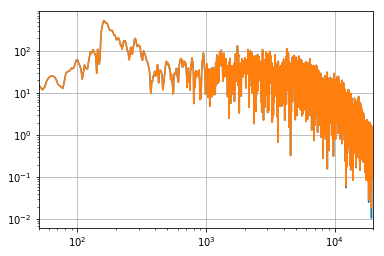

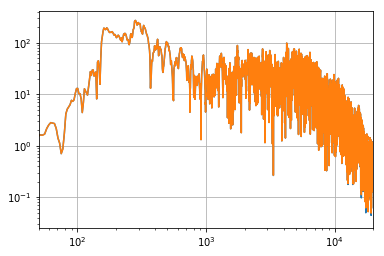

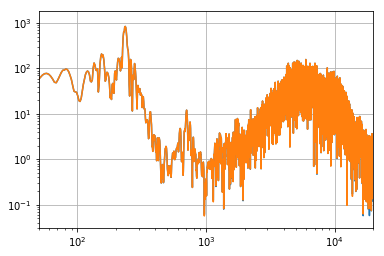

starting optimisation...
22672117002.597347
37168215665.35676
20173782244.11409
23658716089.585808
1553378013.2805028
23955673011.84015
39779873029.79053
24685204949.939793
17552088208.33296
4180344546.3165183
10485094796.301094
1285739690.7337
23921332386.340466
18213222755.87791
25977889424.352325
1276436075.3061152
1282102622.5061507
1364078165.3894382
48763006298.22355
22898275319.562374


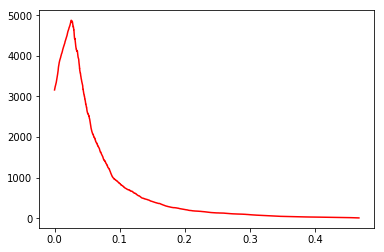

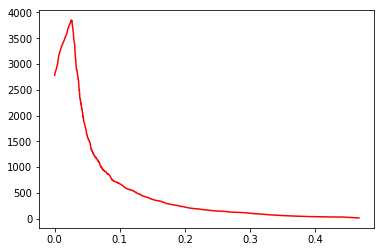

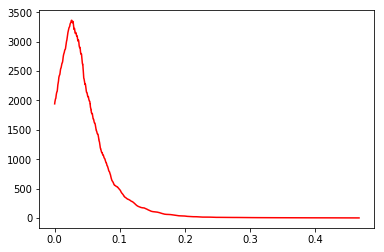

In [348]:
path = "/Users/sam/Dropbox/ai_audio_engineer_training_data/Rock/Samples/Samples_v02/set01"

for file in os.listdir(path):
    print(file)
    
original = os.path.join(path, 'Rock_Raw_SDD_16.wav')
target = os.path.join(path, 'Rock_Mix_SDD_16.wav')

def callback(x, f=None, accept=None):
    if f is not None:
        print(f)
    else:
        temp = tempfile.mktemp()+'.wav'
        tf = equalise(x, scaling)        
        tf.build(original, temp)
        print(equaliser_lse(original, temp))#, scaling*np.array(x))
#         bins = equaliser_bindiff(original, temp)
#         plt.semilogx(bins[0], bins[1])
#         plt.show()

scaling = np.array(
    [10]*9
)
equalised_ret = optimise_equalisation(optimised, target, callback, scaling)
equalised = tempfile.mktemp()+'.wav'
equalise(equalised_ret.x, scaling).build(original, equalised)
equalise(equalised_ret.x, scaling).preview(original)

f_plot(original)
f_plot(target)
f_plot(equalised)

scaling = np.array(
        [0.2, 0.6, 3, -80, -80, 30, 30, 50, 50]
)
compressed_ret = optimise_compression(equalised, target, callback, scaling)
compressed = tempfile.mktemp()+'.wav'
compress(compressed_ret.x, scaling).build(equalised, compressed)
sox.Transformer().preview(original)
sox.Transformer().preview(target)
compress(compressed_ret.x, scaling).preview(compressed)

t_plot(original)
t_plot(target)
t_plot(compressed)

In [243]:
sox.Transformer().preview(original)
sox.Transformer().preview(target)
sox.Transformer().preview(compressed)

In [ ]:
original = FILE
target = tempfile.mktemp()+'.wav'

dt = 0.05

tf = sox.Transformer()
tf.preview(original)
tf.equalizer(70, 7.0, 10.0)
tf.equalizer(4000, 2.0, -50.0)
# tf.equalizer(4000, 6.0, 70.0)
tf.preview(original)
success = tf.build(original, target)

f1 = original
f2 = target

wav1 = read(f1)
data = np.array(wav1[1],dtype=float)[:,0]

# take 0.1 seconds after peak
abs_data = np.abs(data)
max_loc = np.where(abs_data==abs_data.max())[0][0]
sample_data_0 = data[max_loc:max_loc+int(wav1[0]*dt)]
y0 = fft(sample_data_0)

# Number of samplepoints
N = len(sample_data_0)
# sample spacing
T = 1.0 / wav1[0]
x = np.linspace(0.0, 1.0/(2.0*T), N/2)

wav2 = read(f2)
data = np.array(wav2[1], dtype=float)[:,0]

assert(wav2[0] == wav1[0])

# take 0.1 seconds after peak
abs_data = np.abs(data)
max_loc = np.where(abs_data==abs_data.max())[0][0]
sample_data_1 = data[max_loc:max_loc+int(wav1[0]*dt)]
y1 = fft(sample_data_1)

dy = np.log(np.abs(y1[:N//2]))-np.log(np.abs(y0[:N//2]))
f = dy**2
lrange = np.logspace(1, 4, num=30)
bins = []
for lower, upper in zip(lrange[:-1], lrange[1:]):
    indices = np.where(np.logical_and(x > lower, x < upper))[0]
    bins.append(f[indices].sum()/len(indices))

bins = np.array(bins)[1:]
plt.loglog(x, dy**2)
plt.show()
plt.semilogx(lrange[:-1], bins)
print(np.sum(bins[np.logical_not(np.isnan(bins))]))

In [280]:
# tf = sox.Transformer()
# print(tf.stat(FILE))
# print(tf.stats(FILE))

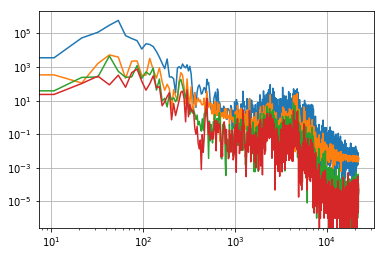

In [151]:
tf = sox.Transformer()
spectrum = np.array(tf.power_spectrum(FILE))
for i in range(4):
    plt.loglog(spectrum[2048*i:2048*(i+1),0], spectrum[2048*i:2048*(i+1),1])
plt.grid(True)
tf.preview(FILE)